### About the notebook

Most of the heavly lifting in the notebook is done by a cool prototyping lib "fastai" (more info at fast.ai and docs.fast.ai/) and PyTorch.
The notebook only serves as an example to kickstart your further developement to train a baseline model on the generated data by Unity Engine.
It uses an unet, resnet34. You can go for a deeper network if you have capable hardware, just simply tweak the constants under "Constants" chapter.

### PREVIOUSLY:

- Fixed mask generation in Unity; built basic unet_learner; best without transfer;
- Started assembling unity hook; server running ok; made the test functions. Problem - cant make a fastapi response with a picture; trying base64 encoding but something fails...
- Make Unity hook

### TODO:

- Generate 5k images; train on that
- Train via "go big" method; turn off some batch augmentations / image tmfs: accuracy, diceloss, training speed checks
- pass accuracy / probability to via API Unity
- build my own Unet?
- top loss heat map?
- real life images check
- try an approach where walls are of background type

### Tried:

- Resnet 50; resnet 14, but 50 is too big; 14 seems too inaccurate;
- Transfer learning sucked - because unity scene not realistic
- <500 images dont train good; >1k images performs quite well; >2k recommended;
- had problems with different image encodings in Unity and fastai; read through PILMask code in fastai to figure it out; it was a Unity issue in labeling had to be linear encoding

### Constants
Pick the depending on the machine you use to train and personal preferences.

- ```batchsize``` sets how big a single train back is, default = 8 (fits well for 11G graphics card and input pic resolution 64x64)
- ```use_transfer``` sets if we use transfer learning or not. Default is False, because unrealistic scenes in Unity are trained not very good.
For real life applications try to make as realistic of a scene as possible (lighting, shaddows, ambient lights, textures, etc.)
- ```big_res_levels```
Increased resolution transfer sizes, they should always be square.
Input aspect ratio and resolution doesnt matter much, they are squished into square before learning and unsquished afterwards. Should keep that in mind when applying in an actual use case though. Both axes must bigger than maximum defined size in big_res_levels.
Default level training is always (64,64). If big_res_levels is empty [], no transfer learning to increase resolution is done.
- ```model_arch```
How deep your network is. My 11 gig card handles resnet34 well, asuming batchsize = 32. If you have more capable hardware, you can try go higher.
- If you have ```len(big_res_levels) > 0```, ```big_epochs``` amount will determine how many epochs will run to make the big picture. Minimum is ```big_epochs > len(big_res_levels) + 1``` because it is a diminishing size for each resolution increment.

In [13]:
batchsize = 64
use_transfer = False
big_res_levels = [128, 256]
from fastai.vision.all import resnet34 as model_arch
small_epochs = 5 #15
big_epochs = 5
save_name = "unity_resnet34"

other choices include: resnet50, resnet101, etc. More info at: https://docs.fast.ai/vision.models.xresnet.html and 
https://fastai1.fast.ai/vision.models.html

### Imports

In [2]:
import pandas as pd
from fastai.vision.all import *
import importlib
import pathlib
import os
import PIL
from numpy import asarray
from notebook_libs.helper_funcs import show_superimposed

In [3]:
path = pathlib.Path().absolute()
path = os.path.join(path, "Assets", "Data~")
def label_func(fn): return os.path.join(path,"labels",f"{fn.stem}{fn.suffix}")
path

'/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~'

In [4]:
codes = pd.read_csv(os.path.join(path,'labels.csv'))
#codes.head()
#codes.shape

In [5]:
fnames = get_image_files(os.path.join(path,"screenshots"))
lnames = get_image_files(os.path.join(path,"labels"))
print(fnames[0])
print(lnames[0])

/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/screenshots/2831.png
/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/labels/2831.png


# Data Loading

## Creating dataloaders

In [6]:
room_dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes.LabelName)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(64,64)))#(120,160)))
dls = room_dblock.dataloaders(os.path.join(path,"screenshots"), path=path, bs=batchsize)

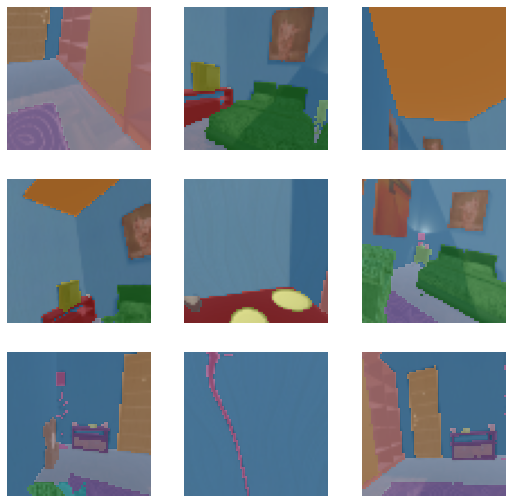

In [7]:
dls.show_batch(vmin=0, vmax=25, cmap='tab20')

## Debuging loaded label images

### See if superimposed is correct

/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/labels/2831.png
/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/screenshots/2831.png


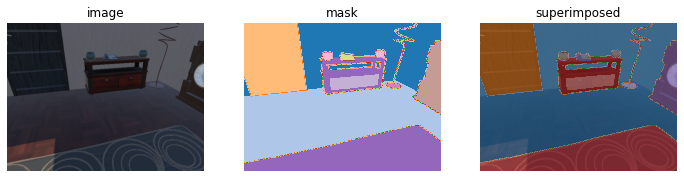

In [8]:
print(lnames[0])
print(fnames[0])
show_superimposed(fnames[0], lnames[0])

### Check if any labels are missing unintentionally

In [9]:
from notebook_libs.helper_funcs import n_code, n_codes, mask_check, debug_label

In [10]:
len_codes = n_codes(lnames)
vals = [v-1 for k, v in len_codes.items()]
#len_codes

In [11]:
#find an out of bounds label name:
for fname in lnames:
    [print(fname, "  label!?:", v) for v in n_code(fname) if v > len(len_codes)+5]

In [12]:
if(len(len_codes) == len(codes.LabelName)):
    print("OK! All items appeared in the dataset! OK!")
else:
    print("Not all items appeared inside the dataset! Please generate larger picture set!")
    print("Missing:")
    codes_mask = ~codes["LabelName"].index.isin(vals)
    print(codes["LabelName"][codes_mask])

OK! All items appeared in the dataset! OK!


In [13]:
#Check if PILMask / Unity doesnt ruin something. These must match:
print(mask_check(lnames[0]))
print(n_code(lnames[0]))

[ 1  2  5  8 13 19 21]
{1, 2, 5, 8, 13, 19, 21}


In [14]:
#Detections:
#codes["LabelName"][mask_check(lnames[0])]

### If needed, print a mask value
Helper function to show a picture with a precise mask pixel value.
Show by opening the file in the viewer.

In [15]:
#debug_label(lnames[0], 1)

In [16]:
#See mask color schema
#plt.imshow(np.array([[0, 1, 2, 4, 5, 6]]), vmin=0, vmax=6, cmap='tab20')

# Training

In [37]:
#changed moms, previously: moms=(0.85, 0.75, 0.85)
learn = unet_learner(dls, model_arch, pretrained = use_transfer, moms=(0.95, 0.85, 0.95), n_out=len(codes["LabelName"])+1, metrics=[foreground_acc, DiceMulti()]).to_fp16()

NameError: name 'dls' is not defined

In [18]:
if use_transfer:
    #learn.lr_find() #uncomment this line if you want to tweak LR before running fill learning. Can use this after every unfreeze step.
    learn.fit_one_cycle(small_epochs//2, slice(3e-5, 5e-3))
    learn.freeze_to(-1)
    learn.fit_one_cycle(small_epochs//2, slice(3e-5, 5e-3))
    learn.unfreeze()
    learn.fit_one_cycle(small_epochs//2, slice(3e-5, 5e-3))

In [19]:
if not use_transfer:
    #learn.lr_find()
    learn.fit_one_cycle(small_epochs, slice(3e-5, 5e-3)) #15

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,1.458905,2.481795,0.583075,0.032502,00:16
1,1.077826,0.730146,0.769336,0.270638,00:15
2,0.847113,0.515338,0.836136,0.398553,00:16
3,0.657817,0.357395,0.893573,0.474355,00:15
4,0.528689,0.329802,0.902016,0.497041,00:15


### Saving small model

In [20]:
export_name = "models/"+save_name
if len(big_res_levels) > 0:
    learn.save(save_name+"_64x")
else:
    learn.export(export_name)

# Results

#### Metrics helper functions

In [21]:
#Source: https://forums.fast.ai/t/plotting-metrics-after-learning/69937/2
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

#### Metrics Plots

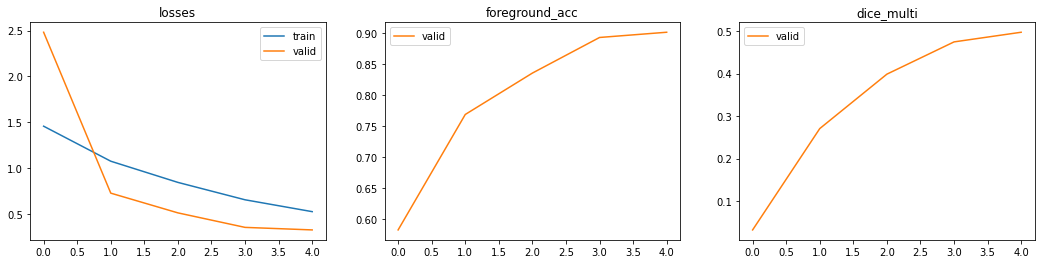

In [22]:
learn.recorder.plot_metrics()

#### Interpertation

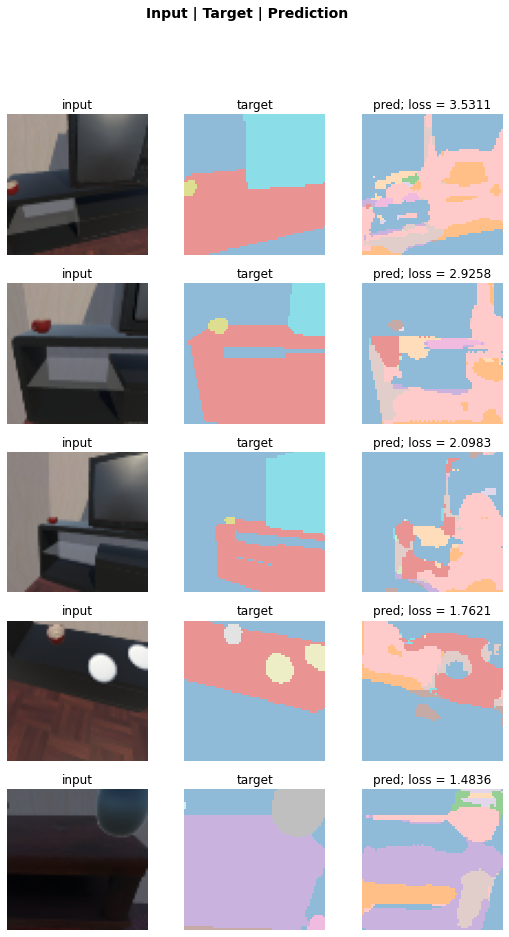

In [23]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=5)

#### Predicting

In [24]:
from fastai.learner import load_learner
import os

from notebook_libs.helper_funcs import show_masked_original_size, path_to_image_bytes, load_image_from_bytes

_test_upload_file = ""
for root, dirs, files in os.walk(
    path, topdown=True, onerror=None, followlinks=False
):
    _test_upload_file = os.path.join(root, files[0])
model_path = os.path.join(path, "models", "unity_resnet34")

print(model_path)
print(_test_upload_file)

/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/models/unity_resnet34
/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/screenshots/2831.png


In [25]:
learner = load_learner(model_path)
img_bytes = path_to_image_bytes(_test_upload_file)
image = load_image_from_bytes(img_bytes)

In [26]:
ima = load_image_from_bytes(path_to_image_bytes(_test_upload_file))
print(ima.shape)
#a = np.delete(ima, 3, axis=2)
#print(a.shape)

(480, 640, 3)


(480, 640)


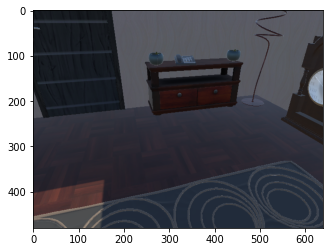

In [27]:
base_img = PILImage.create(fnames[0])
base_img_size = base_img.shape
print(base_img_size)
img_to_learner = np.array(base_img)
plt.imshow(img_to_learner)

(480, 640)


torch.Size([64, 64])


<AxesSubplot:>

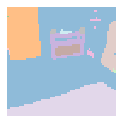

In [28]:
print(base_img.shape)
pred = learner.predict(np.array(base_img))[0]
print(pred.shape)
pred.show()

Here we see that prediction output mask is smaller than original if final training tier is not done on bigger resolution. It will in fact be smaller as long as the final resolution is not of the original camera capture texture resolution. In that case we need to rescale it back up, so that our API returns correct size texture. How we do it can be found in a helper function ```show_masked_original_size```:

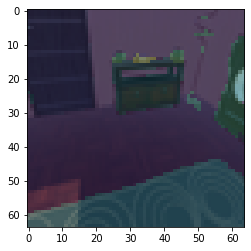

In [29]:
base_img_small = base_img.resize((64,64))
plt.imshow(np.array(base_img_small))
plt.imshow(np.array(pred), alpha=0.25)

(64, 64)  resizing back to  (480, 640)


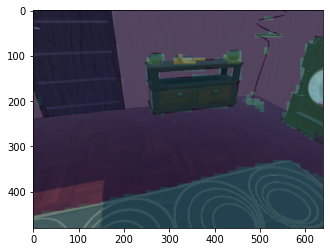

In [30]:
show_masked_original_size(base_img, learner)

### Go Big

So the whole idea by going bigger is to transfer what our model already learned and train a network with more outputs on top of it. If there are memory problems, try restarting the kernel, then run "constants" cell and then continue form here. If it still does not work, try reducing params, like batchsize, resolutions, etc.

In [40]:
from fastai.vision.all import PILImage, get_image_files, DataBlock, unet_learner, ImageBlock, MaskBlock, RandomSplitter, aug_transforms, foreground_acc, DiceMulti
import os, pathlib
path = pathlib.Path().absolute()
path = os.path.join(path, "Assets", "Data~")
fnames = get_image_files(os.path.join(path,"screenshots"))
base_img = PILImage.create(fnames[0])

In [41]:
import pandas as pd
codes = pd.read_csv(os.path.join(path,'labels.csv'))

In [42]:
#testing if resolutions fit:
if max(big_res_levels) > min(base_img.shape):
    raise Exception("Sorry, but your input screenshot is higher resolution than your defined 'big_res_levels' maximum value. It must either match or be smaller than screen.")

In [43]:
def label_func(fn): return os.path.join(path,"labels",f"{fn.stem}{fn.suffix}")

In [44]:
lr = slice(3e-5, 5e-3)
lr

slice(3e-05, 0.005, None)

In [45]:
def train_bigger(epochs, lr, model_name_load, model_name_save, pic_size):
    current_size = (pic_size,pic_size)
    print(current_size)
    curr_batchsize = batchsize // (pic_size // 64) # a double // makes this int type.
    print(curr_batchsize)
    print(lr)
    bigger_block = DataBlock(blocks=(ImageBlock, MaskBlock(codes.LabelName)),
                       get_items = get_image_files,
                       get_y = label_func,
                       splitter=RandomSplitter(),
                       batch_tfms=aug_transforms(size=current_size))#(120,160)))
    dls = bigger_block.dataloaders(os.path.join(path,"screenshots"), path=path, bs=curr_batchsize)
    with unet_learner(dls, model_arch, pretrained = use_transfer, moms=(0.85, 0.75, 0.85), n_out=len(codes["LabelName"])+1, metrics=[foreground_acc, DiceMulti()]) as learn:
        learn.load(model_name_load)
        learn.fit_one_cycle(epochs, lr)
        learn.save(model_name_save)

In [46]:
for i in range(len(big_res_levels)):
    prev_name = "64"
    if i > 0:
        prev_name = big_res_levels[i-1]
    
    name_to_load = save_name+"_"+str(prev_name)+"x"
    name_to_save = save_name+"_"+str(big_res_levels[i])+"x"
    
    epochs = big_epochs - i
    print("Training: "+name_to_save)
    train_bigger(epochs, slice(1e-3), name_to_load, name_to_save, big_res_levels[i])

Training: unity_resnet34_128x
(128, 128)
32
slice(None, 0.001, None)


epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.449145,0.419256,0.855751,0.455377,00:25
1,0.402929,0.239026,0.926021,0.599209,00:22
2,0.330865,0.207964,0.935675,0.642225,00:22
3,0.265694,0.159098,0.952292,0.725450,00:22
4,0.229799,0.151543,0.955199,0.740266,00:22


Training: unity_resnet34_256x
(256, 256)
16
slice(None, 0.001, None)


epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.347393,0.439599,0.886189,0.534256,01:14
1,0.309505,0.182665,0.941522,0.681579,01:11
2,0.219015,0.108524,0.967673,0.779485,01:11
3,0.147309,0.091027,0.971697,0.795715,01:11
